Sqlite3 Database & Helper Classes

In [1]:
import sqlparse
from sqlparse.sql import IdentifierList, Identifier,  Function
from sqlparse.tokens import Keyword, DML
from collections import namedtuple
import itertools
import sqlite3
import os
import pandas as pd
from typing import List

class Reference(namedtuple('Reference', ['schema', 'name', 'alias', 'is_function'])):
    __slots__ = ()

    def has_alias(self):
        return self.alias is not None

    @property
    def is_query_alias(self):
        return self.name is None and self.alias is not None

    @property
    def is_table_alias(self):
        return self.name is not None and self.alias is not None and not self.is_function

    @property
    def full_name(self):
        if self.schema is None:
            return self.name
        else:
            return self.schema + '.' + self.name

def _is_subselect(parsed):
    if not parsed.is_group:
        return False
    for item in parsed.tokens:
        if item.ttype is DML and item.value.upper() in ('SELECT', 'INSERT',
                                                        'UPDATE', 'CREATE', 'DELETE'):
            return True
    return False


def _identifier_is_function(identifier):
    return any(isinstance(t, Function) for t in identifier.tokens)


def _extract_from_part(parsed):
    tbl_prefix_seen = False
    for item in parsed.tokens:
        if item.is_group:
            for x in _extract_from_part(item):
                yield x
        if tbl_prefix_seen:
            if _is_subselect(item):
                for x in _extract_from_part(item):
                    yield x
            # An incomplete nested select won't be recognized correctly as a
            # sub-select. eg: 'SELECT * FROM (SELECT id FROM user'. This causes
            # the second FROM to trigger this elif condition resulting in a
            # StopIteration. So we need to ignore the keyword if the keyword
            # FROM.
            # Also 'SELECT * FROM abc JOIN def' will trigger this elif
            # condition. So we need to ignore the keyword JOIN and its variants
            # INNER JOIN, FULL OUTER JOIN, etc.
            elif item.ttype is Keyword and (
                    not item.value.upper() == 'FROM') and (
                    not item.value.upper().endswith('JOIN')):
                tbl_prefix_seen = False
            else:
                yield item
        elif item.ttype is Keyword or item.ttype is Keyword.DML:
            item_val = item.value.upper()
            if (item_val in ('COPY', 'FROM', 'INTO', 'UPDATE', 'TABLE') or
                    item_val.endswith('JOIN')):
                tbl_prefix_seen = True
        # 'SELECT a, FROM abc' will detect FROM as part of the column list.
        # So this check here is necessary.
        elif isinstance(item, IdentifierList):
            for identifier in item.get_identifiers():
                if (identifier.ttype is Keyword and
                        identifier.value.upper() == 'FROM'):
                    tbl_prefix_seen = True
                    break

def _extract_table_identifiers(token_stream):
    for item in token_stream:
        if isinstance(item, IdentifierList):
            for ident in item.get_identifiers():
                try:
                    alias = ident.get_alias()
                    schema_name = ident.get_parent_name()
                    real_name = ident.get_real_name()
                except AttributeError:
                    continue
                if real_name:
                    yield Reference(schema_name, real_name,
                                    alias, _identifier_is_function(ident))
        elif isinstance(item, Identifier):
            yield Reference(item.get_parent_name(), item.get_real_name(),
                            item.get_alias(), _identifier_is_function(item))
        elif isinstance(item, Function):
            yield Reference(item.get_parent_name(), item.get_real_name(),
                            item.get_alias(), _identifier_is_function(item))

def extract_tables(sql):
    # let's handle multiple statements in one sql string
    extracted_tables = []
    statements = list(sqlparse.parse(sql))
    for statement in statements:
        stream = _extract_from_part(statement)
        extracted_tables.append([ref.name for ref in _extract_table_identifiers(stream)])
    return list(itertools.chain(*extracted_tables))

class CSVDriver:
    def __init__(self, table_dir_path: str):
        self.table_dir_path = table_dir_path  # where tables (ie. csv files) are located
        self._con = None

    @property
    def con(self) -> sqlite3.Connection:
        """Make a singleton connection to an in-memory SQLite database"""
        if not self._con:
            self._con = sqlite3.connect(":memory:")
        return self._con
    
    def _exists(self, table: str) -> bool:
        query = """
        SELECT name
        FROM sqlite_master 
        WHERE type ='table'
        AND name NOT LIKE 'sqlite_%';
        """
        tables = self.con.execute(query).fetchall()
        return table in tables

    def _load_table_to_mem(self, table: str, sep: str = None) -> None:
        """
        Load a CSV into an in-memory SQLite database
        sep is set to None in order to force pandas to auto-detect the delimiter
        """
        if self._exists(table):
            return
        file_name = table + ".csv"
        path = os.path.join(self.table_dir_path, file_name)
        if not os.path.exists(path):
            raise ValueError(f"CSV table {table} does not exist in {self.table_dir_path}")
        df = pd.read_csv(path, sep=sep, engine="python")  # set engine to python to skip pandas' warning
        df.to_sql(table, self.con, if_exists='replace', index=False, chunksize=10000)

    def query(self, query: str) -> List[tuple]:
        """
        Run an SQL query on CSV file(s). 
        Tables are loaded from table_dir_path
        """
        tables = extract_tables(query)
        for table in tables:
            self._load_table_to_mem(table)
        cursor = self.con.cursor()
        cursor.execute(query)  # 'execute' for 1 statement 'executescript' for many
        records = cursor.fetchall()
        return records

Data Prep => Need to get Dates & Timestamps in same format

In [2]:
import csv
from datetime import datetime

sleep = 'sleep'
ready = 'readiness'
workout = 'workout'
mdy_format = '%m/%d/%Y'
input_files = [sleep, workout] #ready

def parse_date(input_file):
  """
  Output csv to formatted dates to 
  faciliate SQL Join
  """

  with open(f"/{input_file}.csv", 'r') as infile, open(f"/t_{input_file}.csv", 'w') as outfile:
    reader = csv.reader(infile)
    headers = next(reader, None)  # returns the headers or `None` if the input is empty
    writer = csv.writer(outfile)
    if headers:
      writer.writerow(headers) # write the header line
    if input_file == sleep:
      for row in reader:
        dt = datetime.fromisoformat(row[1].replace('Z', '+00:00')) #parse the datetime 
        row[1] = dt.strftime(mdy_format)           #assign the revised format
        writer.writerow(row)  
    elif input_file == ready:
      for row in reader:      
        dt = datetime.strptime(row[0], '%Y-%m-%d')    #parse the datetime
        row[0] = dt.strftime(mdy_format)     #assign the revised format
        writer.writerow(row) 
    else: # workout
      for row in reader:    
        writer.writerow(row) # workout date is in mdy_format
  return     

for input_file in input_files:
    parse_date(input_file)

Load tables from database into Pandas dataframe object

In [3]:
from IPython.display import display, HTML
from io import StringIO
import warnings
warnings.filterwarnings('ignore')

db_path = r"/"
driver = CSVDriver(db_path) 

# R.srl_normalized_score, R.hrv_normalized_score,S.resting_heart_rate, 
# S.composition_score, S.revitalization_score, S.duration_score,
sel_query = """
SELECT s.sleep_hrs_mins, S.deep_sleep_in_minutes, S.restlessness,
       W.score_type, W.notes AS rpe     
FROM t_sleep S
LEFT JOIN t_workout W
ON S.timestamp = W.date
AND TRIM(W.score_type) NOT IN ('Load', 'Checkbox')
AND TRIM(W.title) != 'Warm-up';
"""
data = pd.DataFrame.from_records(driver.query(sel_query))
output = StringIO()
#Write df.info to a string buffer
data.info(buf=output)
#put the info back to a dataframe so you can use df.to_html()
data_info =  pd.DataFrame(columns=['Data Info'], data=output.getvalue().split('\n'))
display(HTML(data_info.to_html()))
# print(data.info())
print(data.tail())

,Data Info
0,<class 'pandas.core.frame.DataFrame'>
1,"RangeIndex: 331 entries, 0 to 330"
2,Data columns (total 5 columns):
3,# Column Non-Null Count Dtype
4,--- ------ -------------- -----
5,0 0 331 non-null float64
6,1 1 331 non-null int64
7,2 2 331 non-null float64
8,3 3 260 non-null object
9,4 4 259 non-null object


        0   1         2             3  \
326  6.54  87  0.069694  Other / Text   
327  7.28  75  0.063444          Reps   
328  7.28  75  0.063444          Time   
329  6.35  72  0.059032          Reps   
330  6.35  72  0.059032  Other / Text   

                                                     4  
326     10/18510/22510/305 #3RM @strapd/beltless @RPE9  
327                                  @RPE5 💙 band 50#🤘  
328  #BasementWOD #Ro3Kids Opal 🤒35# DB 5+5 @RPE5/ ...  
329           @325 belted @RPE8 86.666% #5RMHBBS🤬Yeah🤘  
330         95/95/95/115/125/145❤️‍🔥🤘@130bpm avg @RPE4  


Data Prep => normalize data += extract @RPE += format += rename columns += One Hot Encode categorical data

In [4]:
import numpy as np

data['sleep_mins'] = data[0] * 60
data['deepness'] = data[1] / data['sleep_mins']
data['restlessness'] = data[2]

data['rpe'] = data[4].str.extract(r'(@RPE+\d+)', expand=False)
data['rpe'] = data['rpe'].str[4:].astype(float)

# drop sleep_hrs_mins now that we have data normalized to mins
data.drop(columns=[0], inplace=True)
# drop deep_sleep_mins now that we have it mormalized to deepness i.e. deep rate
data.drop(columns=[1], inplace=True)
# drop restlessness now that we have it redefined+sorted
data.drop(columns=[2], inplace=True)
# drop notes now that we've extracted @RPE
data.drop(columns=[4], inplace=True)
# filter data to only rows with RPE value set
data = data[data['rpe'].notnull()]

# data.info()

dict_col_names = {
    3: 'exercise_metric'
}

data.rename(dict_col_names, axis=1, inplace=True)

# # One-hot encode the categorical data 
data = pd.get_dummies(data)

output = StringIO()
#Write df.info to a string buffer
data.info(buf=output)
#put the info back to a dataframe so you can use df.to_html()
data_info =  pd.DataFrame(columns=['Data Info'], data=output.getvalue().split('\n'))
display(HTML(data_info.to_html()))
print(data.tail())
data.describe().transpose()

,Data Info
0,<class 'pandas.core.frame.DataFrame'>
1,"Int64Index: 175 entries, 0 to 330"
2,Data columns (total 12 columns):
3,# Column Non-Null Count Dtype
4,--- ------ -------------- -----
5,0 sleep_mins 175 non-null float64
6,1 deepness 175 non-null float64
7,2 restlessness 175 non-null float64
8,3 rpe 175 non-null float64
9,4 exercise_metric_Calories 175 non-null uint8


     sleep_mins  deepness  restlessness  rpe  exercise_metric_Calories  \
326       392.4  0.221713      0.069694  9.0                         0   
327       436.8  0.171703      0.063444  5.0                         0   
328       436.8  0.171703      0.063444  5.0                         0   
329       381.0  0.188976      0.059032  8.0                         0   
330       381.0  0.188976      0.059032  4.0                         0   

     exercise_metric_Inches  exercise_metric_Meters  \
326                       0                       0   
327                       0                       0   
328                       0                       0   
329                       0                       0   
330                       0                       0   

     exercise_metric_Other / Text  exercise_metric_Points  \
326                             1                       0   
327                             0                       0   
328                             0        

,count,mean,std,min,25%,50%,75%,max
sleep_mins,175.0,376.494857,42.971275,201.000000,365.400000,379.200000,389.100000,486.600000
deepness,175.0,0.182192,0.043773,0.060807,0.151825,0.184599,0.209007,0.321730
restlessness,175.0,0.069014,0.013718,0.043157,0.059900,0.066991,0.076526,0.116041
rpe,175.0,4.285714,1.687878,2.000000,3.000000,4.000000,5.000000,9.000000
exercise_metric_Calories,175.0,0.022857,0.149877,0.000000,0.000000,0.000000,0.000000,1.000000
exercise_metric_Inches,175.0,0.005714,0.075593,0.000000,0.000000,0.000000,0.000000,1.000000
exercise_metric_Meters,175.0,0.057143,0.232781,0.000000,0.000000,0.000000,0.000000,1.000000
exercise_metric_Other / Text,175.0,0.074286,0.262988,0.000000,0.000000,0.000000,0.000000,1.000000
exercise_metric_Points,175.0,0.028571,0.167077,0.000000,0.000000,0.000000,0.000000,1.000000
exercise_metric_Reps,175.0,0.291429,0.455724,0.000000,0.000000,0.000000,1.000000,1.000000


Data clean-up => fix outlier(s), DU

In [5]:
from scipy import stats

# Z score
z = np.abs(stats.zscore(data['rpe']))
threshold = 3

# Position of the outlier
idx_outlier = np.where(z > threshold)
print(data.iloc[idx_outlier])

median_rpe = data['rpe'].quantile(0.50)
outlier_rpe = data['rpe'].quantile(0.999)
# print(outlier_rpe)
# Any thing over 10 needs to be replaced with the median rpe
# data['rpe'] = np.where(data['rpe'] > outlier_rpe, int(median_rpe), data['rpe'])

data.describe().transpose()

Empty DataFrame
Columns: [sleep_mins, deepness, restlessness, rpe, exercise_metric_Calories, exercise_metric_Inches, exercise_metric_Meters, exercise_metric_Other / Text, exercise_metric_Points, exercise_metric_Reps, exercise_metric_Rounds + Reps, exercise_metric_Time]
Index: []


,count,mean,std,min,25%,50%,75%,max
sleep_mins,175.0,376.494857,42.971275,201.000000,365.400000,379.200000,389.100000,486.600000
deepness,175.0,0.182192,0.043773,0.060807,0.151825,0.184599,0.209007,0.321730
restlessness,175.0,0.069014,0.013718,0.043157,0.059900,0.066991,0.076526,0.116041
rpe,175.0,4.285714,1.687878,2.000000,3.000000,4.000000,5.000000,9.000000
exercise_metric_Calories,175.0,0.022857,0.149877,0.000000,0.000000,0.000000,0.000000,1.000000
exercise_metric_Inches,175.0,0.005714,0.075593,0.000000,0.000000,0.000000,0.000000,1.000000
exercise_metric_Meters,175.0,0.057143,0.232781,0.000000,0.000000,0.000000,0.000000,1.000000
exercise_metric_Other / Text,175.0,0.074286,0.262988,0.000000,0.000000,0.000000,0.000000,1.000000
exercise_metric_Points,175.0,0.028571,0.167077,0.000000,0.000000,0.000000,0.000000,1.000000
exercise_metric_Reps,175.0,0.291429,0.455724,0.000000,0.000000,0.000000,1.000000,1.000000


DU => visualize w/ plots

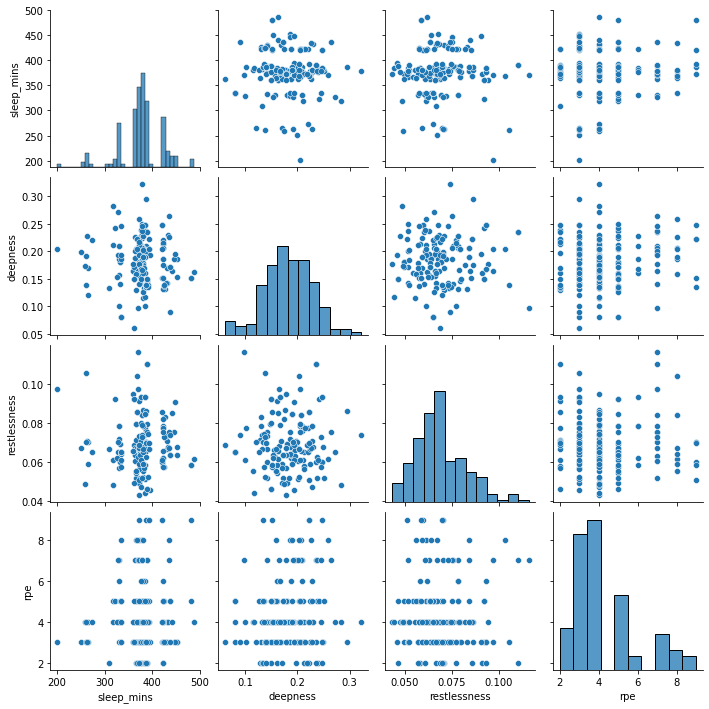

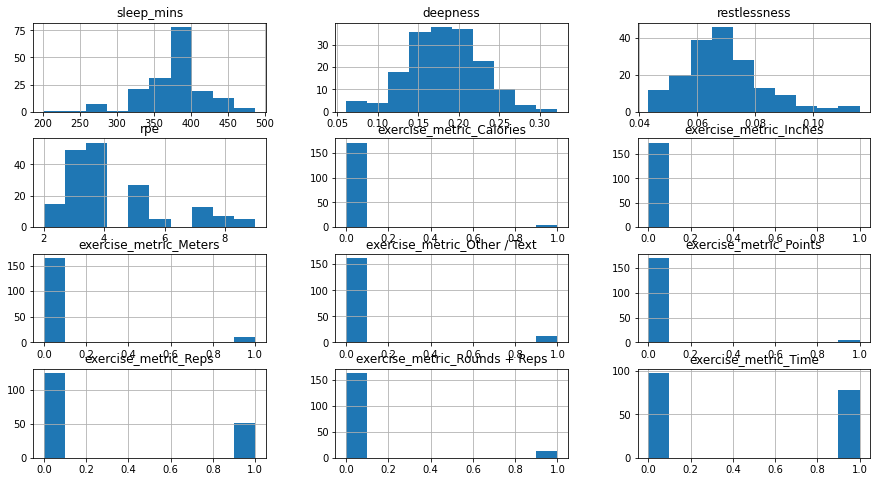

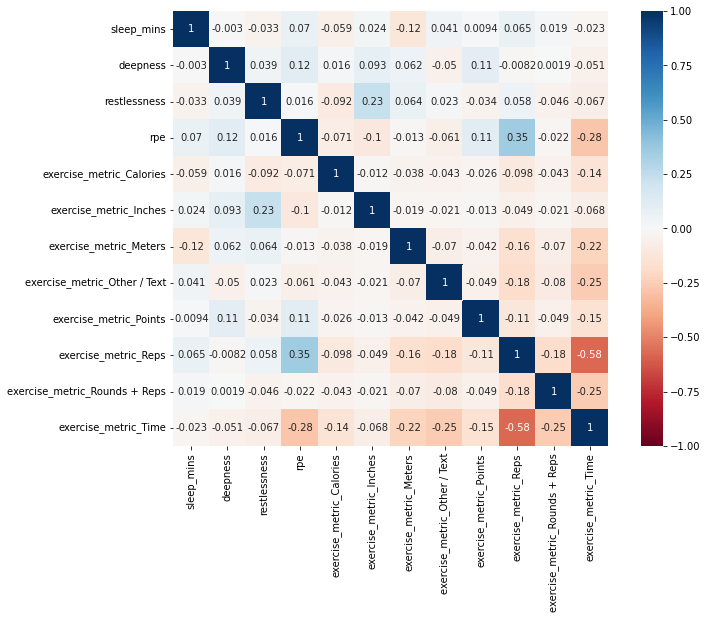

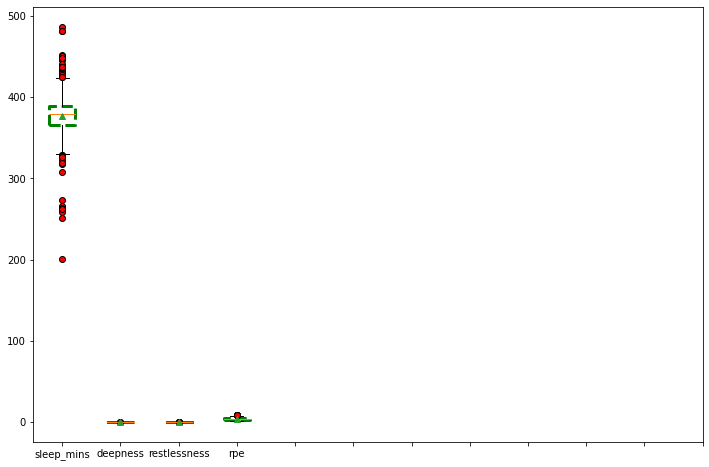

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# visualize the relationship between the features and the response using scatterplots
p = sns.pairplot(data[['sleep_mins', 'deepness', 'restlessness', 'rpe']])

#histplot
def show_hist(x):
    plt.rcParams["figure.figsize"] = 15,8
    x.hist()
show_hist(data)
# data.hist(bins=50, figsize=(15,8))

# correlation matrix
fig, ax = plt.subplots(figsize=(12,8)) 
sns.heatmap(data.corr(), cmap='RdBu', vmin=-1, vmax=1, annot=True, square=True, ax=ax)

# #visualizing distributions 
fig, ax = plt.subplots(figsize=(12,8))
ticks = range(1, len(data.columns)+1)
labels = list(data.select_dtypes(include=['float64', 'int64']).columns)
boxprops = dict(linestyle='--', linewidth=3, color='green')
flierprops = dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none')
numerical_features = data.select_dtypes(include=['float64', 'int64'])
plt.boxplot(numerical_features.transpose(), showmeans=True, boxprops=boxprops, flierprops=flierprops)
plt.xticks(ticks,labels)
plt.show()

Data Prep => Multicollinearity

In [8]:
#Applying multicollinearity to remove columns which are dependent on each other
# From looking at documentation, values between 5 and 10 are "okay".
# Above 10 is too high and so should be removed.
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=10, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = SimpleImputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            try:
                vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
                max_vif = max(vif)
                if max_vif > thresh:
                    maxloc = vif.index(max_vif)
                    print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                    X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                    dropped=True
            except ValueError:  #raised if `vif` is empty.
                pass
        return X     

Data Prep => Feature Engineering + Base pipeline += Split into 80/20 Train/Test for modeling

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# # Remove columns having higher VIF factor that have high multicollinearity
reduce_vif = ReduceVIF()
data = reduce_vif.fit_transform(data)
# # transform data to standardized/normal
data.drop(columns=['exercise_metric_Inches',
                   'exercise_metric_Calories',
                   'exercise_metric_Rounds + Reps',
                   'exercise_metric_Other / Text'], inplace=True)
# show_hist(data)
# fill all nan values w/ mean
# data['rpe'] = data['rpe'].fillna((data['rpe'].mean()))
print(data.describe().transpose())

# Extract features and labels
y = data.loc[:, data.columns == 'rpe']
# List of labels for later use
labels_list = list(y.columns)
print(labels_list)
X = data.loc[:, data.columns != 'rpe']
# List of features for later use
feature_list = list(X.columns)
print(feature_list)
# Convert to numpy arrays
arr_features = np.array(X)
arr_labels = np.array(y)

# split data into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)


# for future piping
numeric_features = feature_list
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler())])

# categorical_features = list(X.select_dtypes(include=['object']).columns)
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])
        # ('cat', categorical_transformer, categorical_features)])

ReduceVIF fit
ReduceVIF transform
Dropping exercise_metric_Time with vif=57.824735865595656
Dropping sleep_mins with vif=30.453466616936232
Dropping restlessness with vif=13.676610561138501
                        count      mean       std       min       25%  \
deepness                175.0  0.182192  0.043773  0.060807  0.151825   
rpe                     175.0  4.285714  1.687878  2.000000  3.000000   
exercise_metric_Meters  175.0  0.057143  0.232781  0.000000  0.000000   
exercise_metric_Points  175.0  0.028571  0.167077  0.000000  0.000000   
exercise_metric_Reps    175.0  0.291429  0.455724  0.000000  0.000000   

                             50%       75%      max  
deepness                0.184599  0.209007  0.32173  
rpe                     4.000000  5.000000  9.00000  
exercise_metric_Meters  0.000000  0.000000  1.00000  
exercise_metric_Points  0.000000  0.000000  1.00000  
exercise_metric_Reps    0.000000  1.000000  1.00000  
['rpe']
['deepness', 'exercise_metric_Meters', 

OLS Model + sklearn LinearRegression + Linear Assumption Tests

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     10.73
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           1.39e-07
Time:                        17:22:30   Log-Likelihood:                -255.96
No. Observations:                 140   AIC:                             521.9
Df Residuals:                     135   BIC:                             536.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                  4

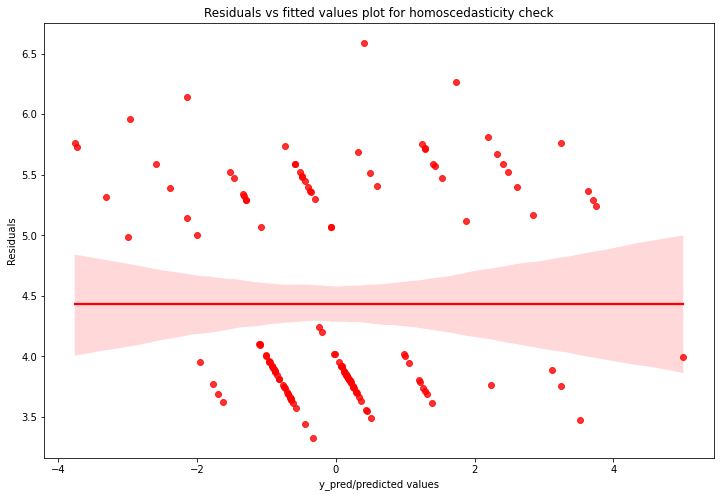

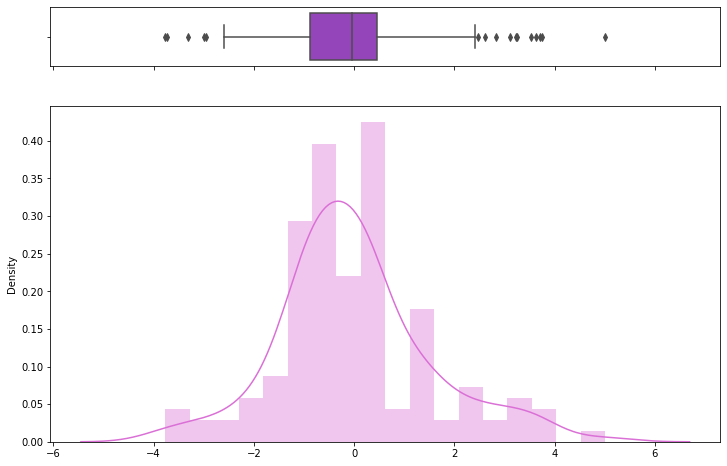

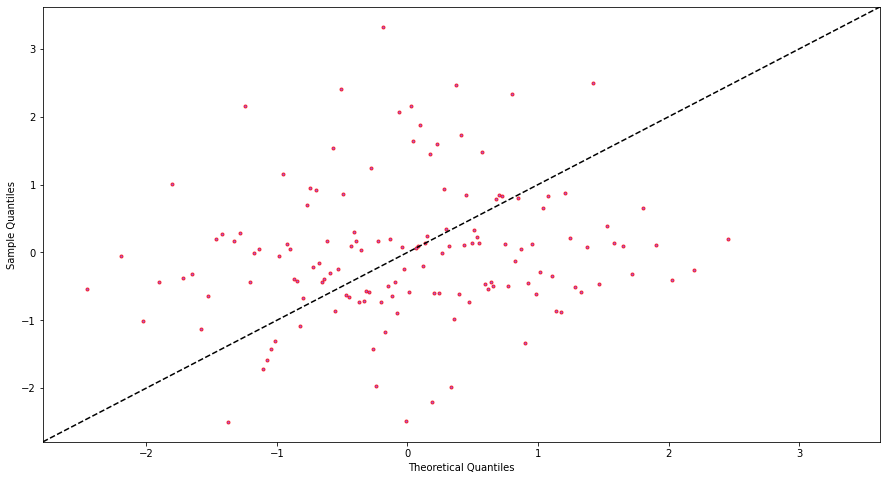

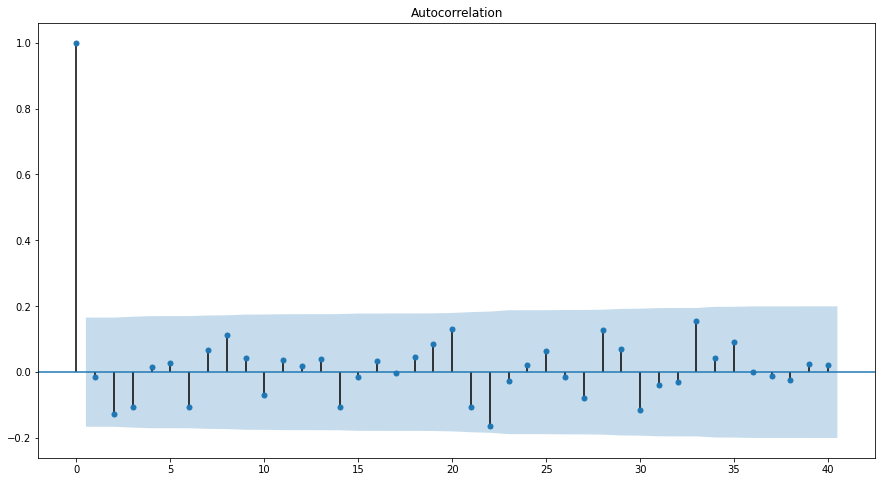

MAE Test = 1.3986824712882906
MSE Test = 3.286358130695549
R2  =      -0.8689826880696594


In [10]:
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import scipy.stats as stats
from sklearn.model_selection import cross_val_score, KFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.estimator_checks import check_estimator
from sklearn import linear_model as lm
from sklearn.metrics import make_scorer, mean_absolute_error as mae, r2_score, mean_squared_error as mse

# Make scorer mae
error_scorer = make_scorer(mae)#greater_is_better=False

class SMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, fit_intercept=True, column_names=()):
        self.column_names = column_names
        self.fit_intercept = fit_intercept


    """
    Parameters
    ------------
    column_names: list
            It is an optional value, such that this class knows 
            what is the name of the feature to associate to 
            each column of X. This is useful if you use the method
            summary(), so that it can show the feature name for each
            coefficient
    """ 
    def fit(self, X_fit, y_fit, column_names=() ):

        if self.fit_intercept:
            X_fit = sm.add_constant(X_fit)

        # Check that X and y have correct shape
        X_fit, y_fit = check_X_y(X_fit, y_fit)

        self.X_ = X_fit
        self.y_ = y_fit
        self.column_names = column_names

        if len(column_names) != 0:
            cols = self.column_names.copy()
            cols = list(cols)  
            df_X = pd.DataFrame(self.X_)
            # print(df_X)
            if self.fit_intercept:
              cols.insert(0,'intercept')
            # print('X ', X)
            df_X.columns = cols

        self.model_ = sm.OLS(self.y_, df_X)
        self.results_ = self.model_.fit()
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, 'model_')

        # Input validation
        X = check_array(X)

        if self.fit_intercept:
          X = sm.add_constant(X)
        return self.results_.predict(X)
    def get_params(self, deep=True):
        return {"fit_intercept": self.fit_intercept, "column_names": self.column_names}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def summary(self):
        print(self.results_.summary() )

pipe=Pipeline([('preprocessor', preprocessor),
               ('estimator', SMWrapper())])

pipe.fit(X_train, y_train, estimator__column_names=feature_list)
print(pipe.named_steps.estimator.summary())

# # define the cross validation procedure
# kfold = KFold(n_splits=3, shuffle=True, random_state=1)
# # evaluate the model
# result = cross_val_score(pipe, X, y, cv=kfold, scoring=error_scorer)
# print(result.mean())

test_results = {}
# The baseline predictions are the RPE averages
baseline_preds = np.mean(y)
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - y_test)
mean_baseline = round(np.mean(baseline_errors.values), 4)
print("Average baseline error: {} sRPEs".format(mean_baseline))
print(f"")

# LinearRegression
pipe=Pipeline([('preprocessor', preprocessor),
               ('estimator', lm.LinearRegression())])
pipe.fit(X_train,y_train)

# train
y_pred = pipe.predict(X_train)
print(f"Linear Regression MAE Train = {mae(y_train, y_pred)}")
print(f"Linear Regression MSE Train = {mse(y_train, y_pred)}")
print(f"Linear Regression R2  =       {r2_score(y_train, y_pred)}")
print(f"")

# #Pull residuals
# residuals = y_test.values - y_pred
residuals = y_train.values-y_pred
# residuals_flattened = residuals.flatten() #np.array(y_train).flatten()-y_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))
print(f"")

# LINEARITY TEST #1 plot Residuals vs Fitted Values
fig, ax = plt.subplots(figsize=(12,8))
sns.regplot(x = residuals, y = y_pred, data = None, scatter = True, color = 'red')
# import pylab as pl
# z = np.sqrt(residuals*residuals+y_pred*y_pred)
# pl.scatter(residuals,y_pred,c=z)
# pl.colorbar()
# pl.xlabel('y_pred/predicted values')
# pl.ylabel('Residuals')
# # pl.ylim(-10,10)
# # pl.xlim(0,26)
# # p = sns.lineplot([0,26],[0,0],color='blue')
# p = pl.title('Residuals vs fitted values plot for homoscedasticity check')

plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
# plt.ylim(-10,10)
# plt.xlim(0,26)
# p = sns.lineplot([0,26],[0,0],color='blue')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

# LINEARITY TEST #2 Checking heteroscedasticity : Using Goldfeld Quandt we test for heteroscedasticity.
# Null Hypothesis: Error terms are homoscedastic
# Alternative Hypothesis: Error terms are heteroscedastic.
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X_train)
print(lzip(name, test))
print('Since p value is more than 0.05 in Goldfeld Quandt Test, we cannot reject its null hypothesis that error terms are homoscedastic => Good.')
print(f"")

# LINEARITY TEST #3 Bartlett’s test tests the null hypothesis that all input samples are from populations with equal variances.
from scipy.stats import bartlett
test = bartlett(np.array(X_train).flatten(),residuals.flatten())
print(test)
print('Since p value is quite less than 0.05 in Bartlett, its null hypothesis that error terms are homoscedastic gets rejected, that is not good for a regression.')
print(f"")

# LINEARITY TEST #4 Normality Plots
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)},figsize=(12,8))
sns.boxplot(residuals, ax=ax_box, color='darkorchid')
sns.distplot(residuals, ax=ax_hist, color='orchid')
ax_box.set(xlabel='')

pp = sm.ProbPlot(residuals, stats.norm, fit=True)
qq = pp.qqplot(marker='.', markerfacecolor='darkorchid', markeredgecolor='red', alpha=0.8)
sm.qqline(qq.axes[0], line='45', fmt='k--')


# LINEARITY TEST #5 autocorrelation
# Checking for autocorrelation To ensure the absence of autocorrelation we use Ljungbox test.
# Null Hypothesis: Autocorrelation is absent.
# Alternative Hypothesis: Autocorrelation is present.
from statsmodels.stats import diagnostic as diag
print("%5.10f Ljungbox test " % min(diag.acorr_ljungbox(residuals , lags = 40)[1]))
print('Since p value is greater than 0.05 we fail to reject the null hypothesis that error terms are not autocorrelated.')
print(f"")
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()

# holdout
y_pred = pipe.predict(X_test)
linear_mae_test = mae(y_test, y_pred)
linear_r2 = r2_score(y_test, y_pred)
print(f"MAE Test = {linear_mae_test}")
print(f"MSE Test = {mse(y_test, y_pred)}")
print(f"R2  =      {linear_r2}")

# R2 for baseline default to OLS
test_results['baseline_preds'] = (linear_r2, mean_baseline)
test_results['linear_Regressor'] = (linear_r2, linear_mae_test)

PLS Model

100% completed
Suggested number of components:  1



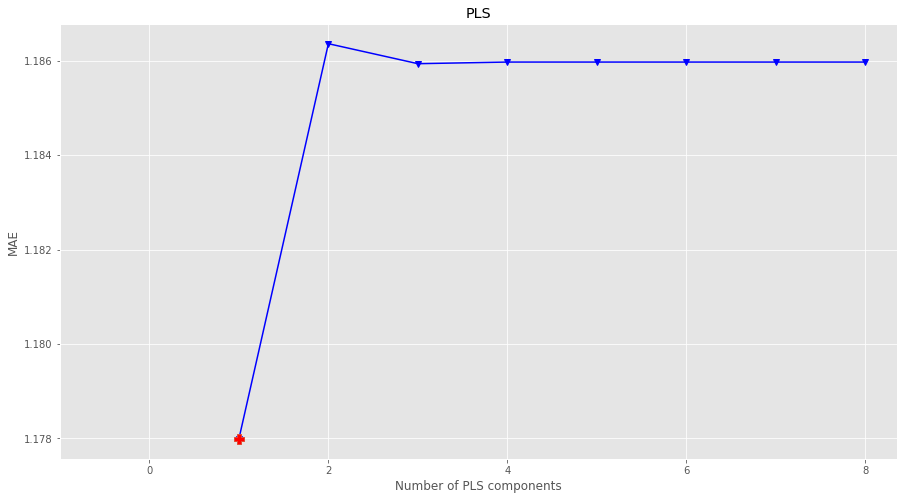

R2 calib: 0.158
R2 CV: 0.063
MAE calib: 1.112
MAE CV: 1.178
MSE calib: 2.386
MSE CV: 2.655


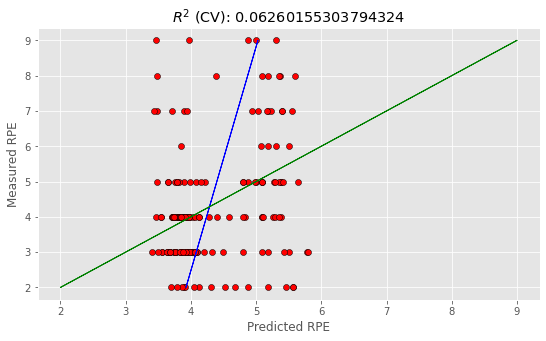

In [11]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sys import stdout

def optimize_pls_cv(X, y, n_comp, plot_components=True):
 
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate R2 & MAE & MSE '''
 
    mae_pls = []
    component = np.arange(1, n_comp)
 
    for i in component:
        pls=Pipeline([('preprocessor', preprocessor),
               ('estimator', PLSRegression(n_components=i))])

        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
 
        mae_pls.append(mean_absolute_error(y, y_cv))
        # print(mae_pls)
        comp = 100*(i+1)/n_comp
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    # Calculate and print the position of minimum in MAE
    mae_min = np.argmin(mae_pls)
    # print(mae_pls)
    print("Suggested number of components: ", mae_min+1)
    stdout.write("\n")
 
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mae_pls), '-v', color = 'blue', mfc='blue')
            plt.plot(component[mae_min], np.array(mae_pls)[mae_min], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MAE')
            plt.title('PLS')
            plt.xlim(left=-1)
 
        plt.show()
 
    # Define PLS object with optimal number of components
    pls_opt=Pipeline([('preprocessor', preprocessor),
                      ('estimator', PLSRegression(n_components=mae_min+1))])    
   
    # Fit to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)

    # Calcullate mean absolute error for calibration and cross-validation
    mae_c = mean_absolute_error(y, y_c)
    mae_cv = mean_absolute_error(y, y_cv)

    test_results['pls_Regressor'] = (score_cv, mae_cv)
 
    # Calculate mean squared error for calibration and cross-validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)

    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MAE calib: %5.3f' % mae_c)
    print('MAE CV: %5.3f' % mae_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
 
    # Plot regression and figures of merit
    # rangey = max(y) - min(y)
    # rangex = max(y_c) - min(y_c)
 
    # Fit a line to the CV vs response
    arr_y = y.values.flatten()
    z = np.polyfit(arr_y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_cv, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted RPE')
        plt.ylabel('Measured RPE')
 
        plt.show()
 
    return

optimize_pls_cv(X,y, 9, plot_components=True)    

Baseline Model: RandomForestRegressorr

Random Forest Regressor MAE Train = 0.5845 sRPEs
Random Forest Regressor MSE Train = 0.654
Random Forest Regressor R2  = 0.7811803159754145

Mean of Residuals -0.013460884353741464


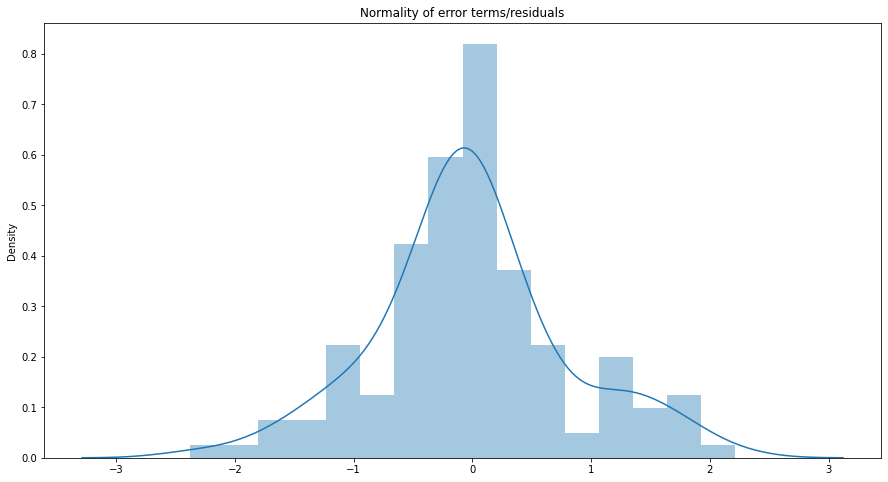

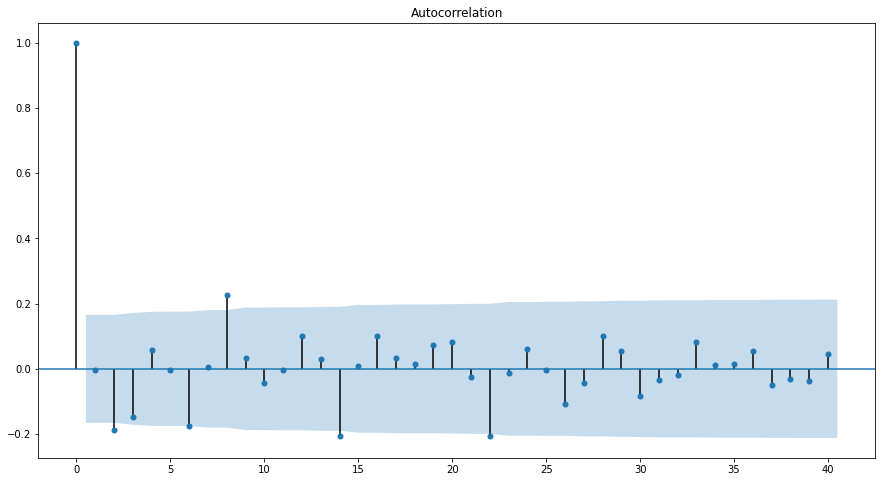

Random Forest Regressor MAE Test = 1.8973442176870752
Random Forest Regressor MSE Test = 6.167
Random Forest Regressor R2  =      -2.5070065292147485
Random Forest Regressor Accuracy: rpe    32.91
dtype: float64 %

Variable: deepness             Importance: 0.73
Variable: exercise_metric_Reps Importance: 0.18
Variable: exercise_metric_Meters Importance: 0.05
Variable: exercise_metric_Points Importance: 0.05


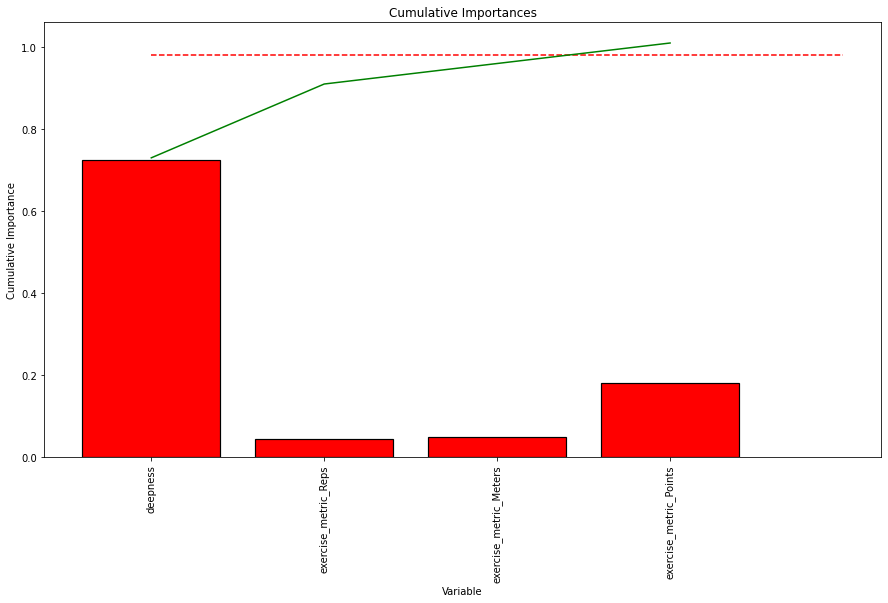

Number of features for 98% importance: 4


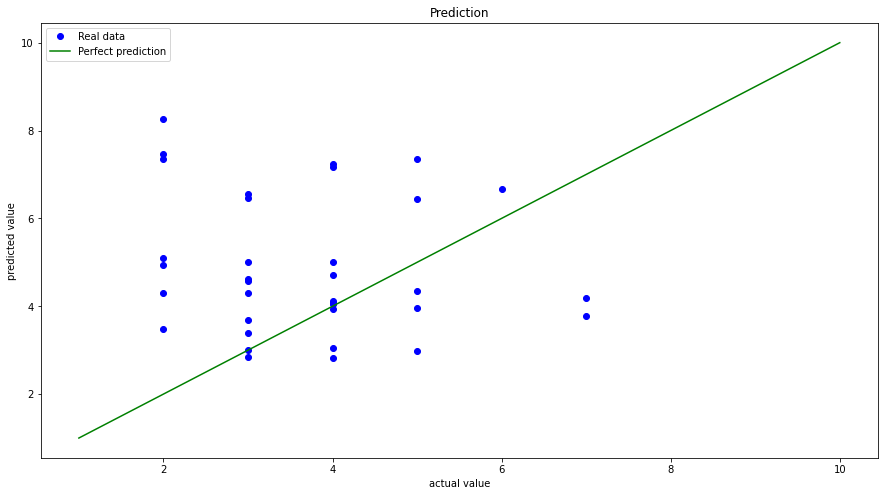

In [12]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate RandomForestRegressor Baseline model w/ 100 decision trees
rf_tree=Pipeline([('preprocessor', preprocessor),
        ('estimator', RandomForestRegressor(n_estimators = 100, random_state = 42))])
rf_tree.fit(X_train,y_train)

# train
rf_tree_y_pred = rf_tree.predict(X_train)
print(f"Random Forest Regressor MAE Train = {round(mean_absolute_error(y_train, rf_tree_y_pred),4)} sRPEs")
print(f"Random Forest Regressor MSE Train = {round(mean_squared_error(y_train, rf_tree_y_pred),4)}")
print(f"Random Forest Regressor R2  = {                 r2_score(y_train, rf_tree_y_pred)}")
print(f"")

# Residual Analysis
residuals = np.array(y_train).flatten()-rf_tree_y_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))

# normality.
p = sns.distplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

# autocorrelation
sm.graphics.tsa.plot_acf(residuals, lags=40) #history.values.reshape(-1).tolist()
plt.show()

# holdout
rf_tree_y_pred = rf_tree.predict(X_test)
rf_tree_r2 = r2_score(y_test, rf_tree_y_pred)
rf_tree_mae = mae(y_test, rf_tree_y_pred)

test_results['rf_tree_base_Regressor'] = (rf_tree_r2, rf_tree_mae)
print(f"Random Forest Regressor MAE Test = {rf_tree_mae}")
print(f"Random Forest Regressor MSE Test = {round(mse(y_test, rf_tree_y_pred),3)}")
print(f"Random Forest Regressor R2  =      {rf_tree_r2}")

# Calculate the absolute errors
y_pred_reshaped = rf_tree_y_pred.reshape(rf_tree_y_pred.size,1)
errors = abs(y_pred_reshaped - y_test)

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print("Random Forest Regressor Accuracy: {} %".format(round(accuracy, 2)))
print(f"")

# Get numerical feature importances
importances = list(rf_tree.named_steps.estimator.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 98% of importance retained
plt.hlines(y = 0.98, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');
plt.show()
# Find number of features for cumulative importance of 98%
# Add 1 because Python is zero-indexed
print('Number of features for 98% importance:', np.where(cumulative_importances > 0.98)[0][0] + 1)

# Plot ideal plot against prediction
plt.plot(y_test, rf_tree_y_pred,'bo', label = 'Real data')
plt.plot([1,10], [1,10], color = 'green', label = 'Perfect prediction')
plt.title('Prediction')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.legend()
plt.show()

Models => RandomForestRegressor (Hypertuning)

In [14]:
try:
    import bayes_opt
except ImportError:
    !pip install bayesian-optimization

from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

def kfold_score(clf,X,y,n_fold):
    X,y = X.values,y.values
    kfold = KFold(n_splits=n_fold, shuffle=True, random_state=42)
    accuracy_list = []

    for train_index, test_index in kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        # accuracy_test = r2_score(y_test_fold, preds)
        # Performance metrics
        error = abs(preds - y_test_fold)
        # print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
        # Calculate mean absolute percentage error (MAPE)
        mape = 100 * (error / y_test_fold)
        # Calculate and display accuracy
        accuracy = 100 - np.mean(mape)        
        accuracy_list.append(error)
        arr_accuracy = np.array(accuracy_list)
    return np.array(accuracy_list).mean()

def bo_params_rf(n_estimators,max_depth,min_samples_split,min_samples_leaf):
    
    params = {'n_estimators': int(n_estimators),
               'max_depth': int(max_depth),
               'min_samples_split': int(min_samples_split),
               'min_samples_leaf': int(min_samples_leaf),
              }
    clf = RandomForestRegressor(n_estimators=params['n_estimators'],
                                 max_depth=params['max_depth'],
                                min_samples_split=params['min_samples_split'],
                                min_samples_leaf=params['min_samples_leaf']
                                )
    score = kfold_score(clf,X_train, y_train,5)
    return score  

rf_bo = BayesianOptimization(bo_params_rf, {'n_estimators': (200, 1000),
                                            'max_depth': (10, 100),
                                            'min_samples_split': (50, 100),
                                            'min_samples_leaf': (5, 10)})
results = rf_bo.maximize(init_points=10, n_iter=10, acq='ei')    

params = rf_bo.max['params']
params['n_estimators']= round(params['n_estimators'])
params['max_depth']= round(params['max_depth'])
params['min_samples_split'] = round(params['min_samples_split'])
params['min_samples_leaf'] = round(params['min_samples_leaf'])

print(params)

rf_opt = RandomForestRegressor(n_estimators=params['n_estimators'],
                                max_depth=params['max_depth'],
                                min_samples_split=params['min_samples_split'],
                                min_samples_leaf=params['min_samples_leaf'])
# rf_opt.fit(X_train,y_train)
# preds = rf_opt.predict(X_test)
# print(f"Random Forest Regressor R2  = {                 r2_score(y_test, preds)}")

# cv = KFold(n_splits=5, random_state=123, shuffle=True)
# scores = []
    
# for (train, test), i in zip(cv.split(X, y), range(5)):
#     rf_opt.fit(X.iloc[train], y.iloc[train])
#     preds = rf_opt.predict(X.iloc[test])    
#     # accuracy = r2_score(y.iloc[test], preds)
#     # Performance metrics
#     error = abs(preds - y.iloc[test].values.reshape(35,1))
#     # print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
#     # Calculate mean absolute percentage error (MAPE)
#     mape = 100 * (error / y.iloc[test].values.reshape(35,1))
#     # Calculate and display accuracy
#     accuracy = 100 - np.mean(mape)
#     # print('Accuracy:', round(accuracy, 2), '%.')    
#     scores.append(error)

# arr_error = np.array(scores)
# print("%0.2f KFold validation MAE on test set with a standard deviation of %0.2f" % (arr_error.mean(), arr_error.std()))
# evaluate model with standardized dataset
pipe=Pipeline(steps=[('preprocessor', preprocessor),
                     ('estimator', rf_opt)])
pipe.fit(X_train, y_train)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results = cross_val_score(pipe, X, y, cv=kfold, scoring=error_scorer)
print("%0.3f MAE with a standard deviation between the folds of %0.2f" % (results.mean(), results.std()))
rf_tuned_y_pred = rf_tree.predict(X_test)
rf_tuned_r2 = r2_score(y_test, rf_tuned_y_pred)
test_results['rf_tuned_Regressor'] = (rf_tuned_r2, results.mean())

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 1.362     | 92.92     | 9.359     | 70.8      | 801.2     |
| 2         | 1.359     | 33.52     | 7.597     | 97.38     | 313.0     |
| 3         | 1.406     | 78.35     | 5.471     | 62.6      | 410.1     |
| 4         | 1.357     | 39.03     | 7.662     | 74.01     | 271.0     |
| 5         | 1.361     | 21.72     | 6.579     | 93.07     | 825.7     |
| 6         | 1.359     | 40.56     | 6.249     | 85.37     | 472.6     |
| 7         | 1.358     | 39.06     | 6.632     | 79.08     | 409.0     |
| 8         | 1.359     | 35.92     | 5.424     | 98.62     | 883.5     |
| 9         | 1.388     | 61.32     | 5.615     | 67.86     | 673.0     |
| 10        | 1.36      | 69.71     | 7.209     | 86.97     | 424.8     |
| 11        | 1.397     | 60.22     | 7.799     | 64.32     | 671.5     |
| 12        | 1.405     | 81.26     | 

Modeling => Base Regression MLP

{'learning_rate': 0.005, 'batch_size': 32, 'epochs': 50, 'neurons': 4}
2.330 MAE with a standard deviation between the folds of 0.37
2.414 MAE nn_base_MLPRegressor
{'baseline_preds': (-0.8689826880696594, 1.2122), 'linear_Regressor': (-0.8689826880696594, 1.3986824712882906), 'pls_Regressor': (0.06260155303794324, 1.1779847916005541), 'rf_tree_base_Regressor': (-2.5070065292147485, 1.8973442176870752), 'rf_tuned_Regressor': (-2.5070065292147485, 1.172018740874755), 'nn_base_MLPRegressor': (-3.3136367093997787, 2.41383317348698), 'nn_bo_MLPRegressor': (0.0804897582557681, 0.9901914427908711)}


,R2,MAE [RPE]
baseline_preds,-0.868983,1.212200
linear_Regressor,-0.868983,1.398682
nn_base_MLPRegressor,-3.313637,2.413833
nn_bo_MLPRegressor,0.080490,0.990191
pls_Regressor,0.062602,1.177985
rf_tree_base_Regressor,-2.507007,1.897344
rf_tuned_Regressor,-2.507007,1.172019


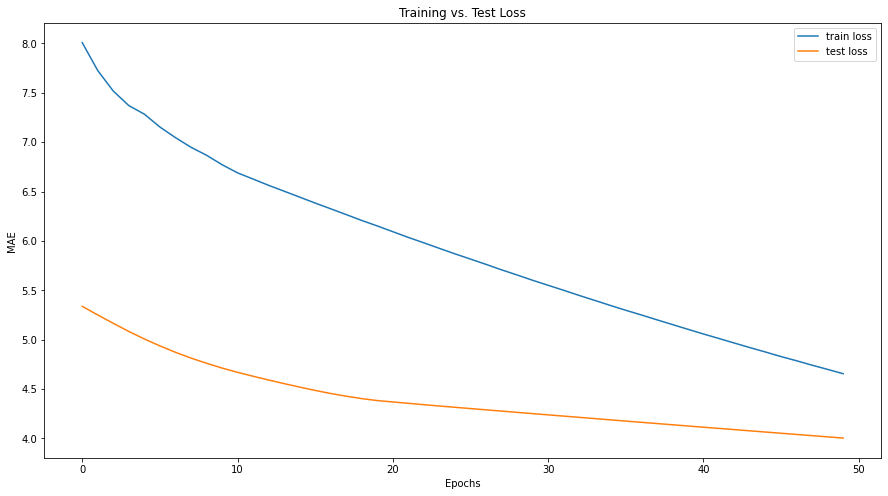

In [57]:
# try:
#     import scikeras
# except ImportError:
#     !pip install scikeras

# from scikeras.wrappers import KerasRegressor
from sklearn.neural_network import MLPRegressor
from typing import Dict, Iterable, Any
from sklearn.model_selection import cross_val_score, KFold
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error as mae
from keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.metrics import MeanSquaredError, MeanAbsoluteError
from keras.callbacks import EarlyStopping
from keras.constraints import MaxNorm
LeakyReLU = LeakyReLU(alpha=0.1)
from keras.utils import normalize

# Silence TensorFlow logging to keep output succinct.
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

n_features = X_train.shape[1]

params_nn_ = {}

params_nn ={
    'neurons': 10,
    'activation':'relu',
    'optimizer': 'adam',
    'learning_rate': 0.005, 
    'batch_size': 32,
    'epochs': 50,
    'neurons': n_features,
    'regularization': 0.0001,
}

params_nn_['learning_rate'] = params_nn['learning_rate']
params_nn_['batch_size'] = params_nn['batch_size']
params_nn_['epochs'] = params_nn['epochs']
params_nn_['neurons'] = params_nn['neurons']
print(params_nn_)
learning_rate=params_nn_['learning_rate']
batch_size=params_nn_['batch_size'] = params_nn['batch_size']
epochs=params_nn_['epochs']
neurons=params_nn_['neurons'] 

# class MLPRegressor():

#     def __init__(
#         self,
#         neurons=params_nn_['neurons'],
#         activation=params_nn_['activation'],
#         k_init='he_normal',
#         optimizer=params_nn_['optimizer'], #'adam'
#         optimizer__learning_rate=learning_rate,#0.01
#         optimizer__clipnorm=1, # fix gradient exploding
#         batch_size=params_nn_['batch_size'],
#         epochs=params_nn_['epochs'],
#         l1 = params_nn_['layers1'],
#         l2 = params_nn_['layers2'],
#         norm = params_nn_['normalization'],
#         dropout = params_nn_['dropout'],
#         dropout_rate = params_nn_['dropout_rate'],
#         verbose=False,
#         callbacks=[EarlyStopping(monitor='mse', mode='min', verbose=0, patience=20)],
#         **kwargs,
#     ):
#         super().__init__(**kwargs)
#         self.neurons = neurons
#         self.activation = activation
#         self.k_init = k_init
#         self.optimizer = optimizer
#         self.batch_size = batch_size
#         self.epochs = epochs
#         self.l1 = l1
#         self.l2 = l2
#         self.norm = norm
#         self.dropout = dropout
#         self.dropout_rate = dropout_rate
#         self.verbose = verbose  

#     # Base regression model with capes to feed optimized hyperparams & layers!
#     def _keras_build_fn(self, compile_kwargs: Dict[str, Any]):
#       #TODO: kernel_constraint=unit_norm()))
#         nn = Sequential()
#         inp = Input(shape=(self.n_features_in_))
#         nn.add(inp)
#         nn.add(BatchNormalization())
#         nn.add(Dense(self.neurons, input_dim=self.n_features_in_, activation=self.activation, kernel_initializer=self.k_init ))
#         if self.norm > 0.5:
#           nn.add(BatchNormalization())
#         for i in range(self.l1):
#           nn.add(Dense(self.neurons, activation=self.activation, kernel_initializer=self.k_init ))
#           nn.add(BatchNormalization())
#         if self.dropout > 0.5:
#           nn.add(Dropout(self.dropout_rate, seed=123))
#         for i in range(self.l2):
#           nn.add(Dense(self.neurons, activation=self.activation, kernel_initializer=self.k_init ))
#           nn.add(BatchNormalization())
#         nn.add(Dense(1, activation='relu'))
#         nn.compile(loss='mae', optimizer=self.optimizer, metrics=[MeanAbsoluteError()])
#         return nn

# evaluate model with standardized dataset
# pipe=Pipeline(steps=[('preprocessor', preprocessor),
#                      ('estimator', MLPRegressor())])

# scale data
from sklearn import preprocessing
X_scaled = preprocessing.scale(X_train);


# instantiate  & fit model
mlp_regr = MLPRegressor(
    # what if we change our layer sizes?
    hidden_layer_sizes=(neurons, neurons*2, round(neurons/2)), 
    # what if we change our learning rate?
    learning_rate_init=learning_rate,
    # what if we change our activation function? (relu, tanh, identity)
    # default to no regularization
    alpha=0,
    batch_size=batch_size,
    max_iter=epochs,
    early_stopping=True,
    random_state=42, # if set to None, this is random, to an int, static seed
    # set this to True to see how well we are learning over the iterations
    verbose=False
)
mlp_regr.fit(X_scaled, y_train)
X_scaled = preprocessing.scale(X_test)
plt.plot(mlp_regr.loss_curve_, label='train loss')
mlp_regr.fit(X_scaled,y_test)
plt.plot(mlp_regr.loss_curve_, label='test loss')
# Axis labels and title
plt.ylabel('MAE'); plt.xlabel('Epochs'); plt.title('Training vs. Test Loss');
plt.legend()
# Plot the 'loss_curve_' property on model to see how well we are learning over the iterations
# Use Pandas built in plot method on DataFrame to creat plot in one line of code
# pd.DataFrame(mlp_regr.loss_curve_).plot()

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results = cross_val_score(mlp_regr, X, y, cv=kfold, scoring=error_scorer)
print("%0.3f MAE with a standard deviation between the folds of %0.2f" % (results.mean(), results.std()))

# _, mlp_base_train_mae = mlp_regr.evaluate(x=X_train, y=y_train, verbose=0)
# _, mlp_base_test_mae = mlp_regr.evaluate(x=X_test, y=y_test, verbose=0)
# print('Train: %.3f, Test: %.3f' % (mlp_base_train_mae, mlp_base_test_mae))

nn_base_MLPRegressor_y_pred = mlp_regr.predict(X_test)
nn_base_MLPRegressor_mae = mae(y_test, nn_base_MLPRegressor_y_pred)
print("%0.3f MAE nn_base_MLPRegressor" % nn_base_MLPRegressor_mae)
nn_base_MLPRegressor_r2 = r2_score(y_test, nn_base_MLPRegressor_y_pred)
test_results['nn_base_MLPRegressor'] = (nn_base_MLPRegressor_r2, nn_base_MLPRegressor_mae)
print(test_results)
df_test_results = pd.DataFrame.from_records(test_results).T
df_test_results.rename({0: 'R2', 1: 'MAE [RPE]'}, axis=1, inplace=True)
display(HTML(df_test_results.to_html()))
# print(df_test_results)

Modeling => prediction plots Base MLPRegressor

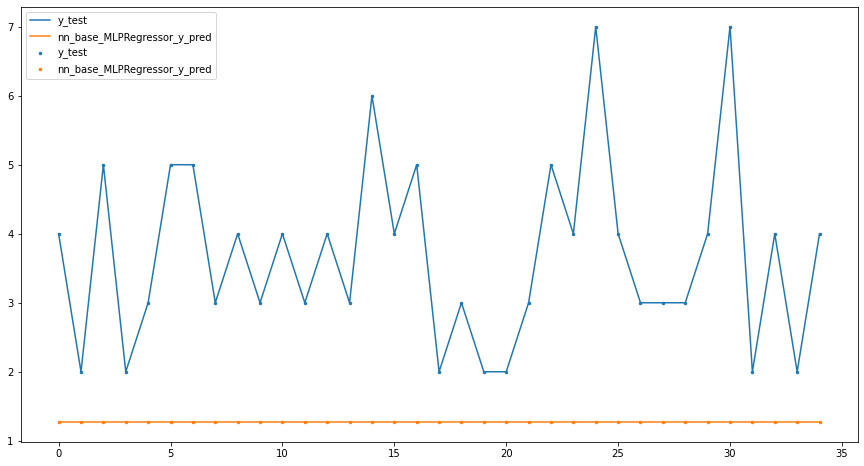

In [35]:
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test,  s=6, label="y_test")
plt.scatter(x_ax, nn_base_MLPRegressor_y_pred,  s=6, label="nn_base_MLPRegressor_y_pred")
plt.plot(x_ax, y_test, label="y_test")
plt.plot(x_ax, nn_base_MLPRegressor_y_pred, label="nn_base_MLPRegressor_y_pred")
plt.legend()
plt.show()

Modeling => Tune hyperparams & layers += pipe thru Regression MLP

|   iter    |  target   | batch_... |  epochs   | learni... |  neurons  | regula... |
-------------------------------------------------------------------------------------
| 1         | 1.365     | 33.98     | 191.1     | 0.732     | 6.395     | 0.01156   |
| 2         | 1.348     | 23.49     | 30.46     | 0.8662    | 6.404     | 0.01708   |
| 3         | 1.354     | 16.99     | 194.6     | 0.8325    | 4.849     | 0.01182   |
| 4         | 1.34      | 24.8      | 74.76     | 0.5248    | 5.728     | 0.01291   |
| 5         | 1.267     | 45.37     | 45.11     | 0.2922    | 5.465     | 0.01456   |
| 6         | 1.334     | 53.69     | 55.94     | 0.5143    | 6.37      | 0.01046   |
| 7         | 1.394     | 45.16     | 50.69     | 0.06515   | 7.796     | 0.01966   |
| 8         | 1.243     | 54.8      | 74.83     | 0.09776   | 6.737     | 0.0144    |
| 9         | 1.421     | 21.86     | 109.1     | 0.03449   | 7.637     | 0.01259   |
| 10        | 1.335     | 47.8      | 76.11     | 0.52

,R2,MAE [RPE]
baseline_preds,-0.868983,1.212200
linear_Regressor,-0.868983,1.398682
nn_base_MLPRegressor,-3.313637,2.413833
nn_bo_MLPRegressor,0.080490,0.990191
pls_Regressor,0.062602,1.177985
rf_tree_base_Regressor,-2.507007,1.897344
rf_tuned_Regressor,-2.507007,1.172019


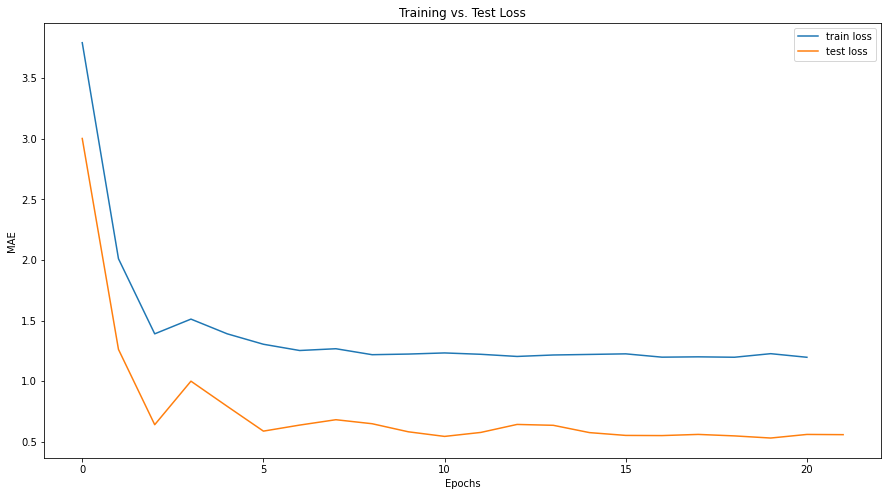

In [58]:
try:
    import bayes_opt
except ImportError:
    !pip install bayesian-optimization

# try:
#     import scikeras
# except ImportError:
#     !pip install scikeras

# from scikeras.wrappers import KerasRegressor
from bayes_opt import BayesianOptimization
from keras.optimizers import Adam, SGD#, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from sklearn import preprocessing

# Make scorer mae
error_scorer = make_scorer(mean_absolute_error)#, greater_is_better=False

# Create function for tuning the NN hyperparameters and layers.
def nn_cl_bo(learning_rate, batch_size, epochs,neurons, regularization):
    batch_size = round(batch_size)
    epochs = round(epochs)
    neurons = round(neurons)
        
    nn = MLPRegressor(
        hidden_layer_sizes=(neurons, neurons*2, round(neurons/2)),
        learning_rate_init=learning_rate,
        batch_size=batch_size,
        max_iter=epochs,
        alpha=regularization,
        early_stopping=True,
        random_state=42, # if set to None, this is random, to an int, static seed
        # set this to True to see how well we are learning over the iterations
        verbose=False
    )
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    X_scaled = preprocessing.scale(X_train);
    score = cross_val_score(nn, X_scaled, y_train, scoring=error_scorer, cv=kfold).mean()
    # print(score)
    return score

params_nn ={
    'learning_rate':(0.0001, 1),
    'batch_size':(16, 64),
    'epochs':(20, 200),
    'neurons': (n_features, n_features*2),
    'regularization':(.01,.02) #0.1, 0.5
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo, params_nn, random_state=42)
results = nn_bo.maximize(init_points=10, n_iter=10, acq='ei') 

params_nn_ = nn_bo.max['params']
learning_rate = params_nn_['learning_rate']
batch_size= round(params_nn_['batch_size'])
epochs= round(params_nn_['epochs'])
neurons= round(params_nn_['neurons'])
# optimizerL = ['Adam', 'SGD']#'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','Adam'
# optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate)}

#             #  'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
#             #  'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
#             #  'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
# optimizer = optimizerD[optimizerL[round(params_nn_['optimizer'])]]
regularization=params_nn_['regularization']
print(params_nn_)

# evaluate hypertuned & regularized nn model with standardized dataset
# pipe=Pipeline(steps=[('preprocessor', preprocessor),
#                      ('estimator', MLPRegressor())])
# pipe.fit(X_train, y_train)


# scale data
X_scaled = preprocessing.scale(X_train);

# instantiate  & fit model
mlp_regr = MLPRegressor(
    hidden_layer_sizes=(neurons, neurons*2, round(neurons/2)), 
    learning_rate_init=learning_rate,
    batch_size=batch_size,
    max_iter=epochs,
    alpha=regularization,
    early_stopping=True,
    random_state=42, # if set to None, this is random, to an int, static seed
    # set this to True to see how well we are learning over the iterations
    verbose=False
)
mlp_regr.fit(X_scaled, y_train)
X_scaled = preprocessing.scale(X_test)
plt.plot(mlp_regr.loss_curve_, label='train loss')
mlp_regr.fit(X_scaled,y_test)
plt.plot(mlp_regr.loss_curve_, label='test loss')
plt.ylabel('MAE'); plt.xlabel('Epochs'); plt.title('Training vs. Test Loss');
plt.legend()

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results = cross_val_score(mlp_regr, X, y, cv=kfold, scoring=error_scorer)
print("%0.3f MAE with a standard deviation between the folds of %0.2f" % (results.mean(), results.std()))
# test_results['nn_bo_MLPRegressor'] = results.mean()
# _, mlp_bo_train_mae = pipe.named_steps.estimator.model_.evaluate(x=X_train, y=y_train, verbose=0)
# _, mlp_bo_test_mae = pipe.named_steps.estimator.model_.evaluate(x=X_test, y=y_test, verbose=0)
# print('Train: %.3f, Test: %.3f' % (mlp_bo_train_mae, mlp_bo_test_mae))

#*********Deployment Test****************
deploy_X_test = {'deepness': [0.2063, 0.2, 0.1806, 0.2, 0.1125, 0.2066, 0.1926],
                 'exercise_metric_Meters': [0,0,0,0,1,0,0],
                 'exercise_metric_Points': [0,1,0,0,0,0,1],
                 'exercise_metric_Reps': [1,0,1,0,0,1,0]}
df_deploy_X_test = pd.DataFrame(deploy_X_test)
# print(df_deploy_X_test)
nn_base_MLPRegressor_deploy_y_pred = mlp_regr.predict(df_deploy_X_test)
print('nn_base_MLPRegressor_deploy_y_pred => ', nn_base_MLPRegressor_deploy_y_pred)
#****************************************
nn_bo_MLPRegressor_y_pred = mlp_regr.predict(X_test)
nn_bo_MLPRegressor_mae = mae(y_test, nn_bo_MLPRegressor_y_pred)
nn_bo_MLPRegressor_r2 = r2_score(y_test, nn_bo_MLPRegressor_y_pred)
test_results['nn_bo_MLPRegressor'] = (nn_bo_MLPRegressor_r2, nn_bo_MLPRegressor_mae)
df_test_results = pd.DataFrame.from_records(test_results).T
df_test_results.rename({0: 'R2', 1: 'MAE [RPE]'}, axis=1, inplace=True)
display(HTML(df_test_results.to_html()))
# print(df_test_results)

Modeling => prediction plots Tuned MLPRegressor

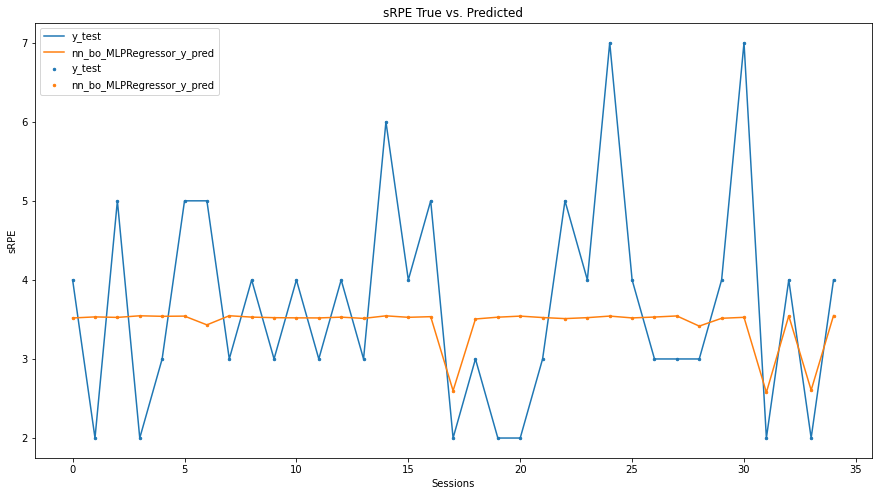

In [38]:
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test,  s=6, label="y_test")
plt.scatter(x_ax, nn_bo_MLPRegressor_y_pred,  s=6, label="nn_bo_MLPRegressor_y_pred")
plt.plot(x_ax, y_test, label="y_test")
plt.plot(x_ax, nn_bo_MLPRegressor_y_pred, label="nn_bo_MLPRegressor_y_pred")
plt.ylabel('sRPE'); plt.xlabel('Sessions'); plt.title('sRPE True vs. Predicted')
plt.legend()
plt.show()

MLP for combined regression + classification predictions

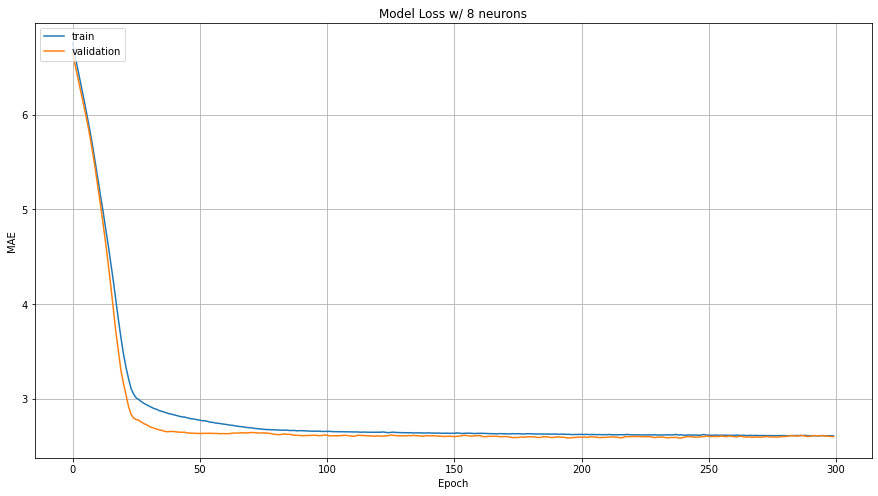

2/2 [==============================] - 0s 7ms/step
Test R2:  -0.362
Test MAE: 1.283
Test Accuracy: 0.293


In [39]:
from sklearn.preprocessing import LabelEncoder
from numpy import unique
from numpy import argmax
from keras.models import Model
from sklearn.metrics import accuracy_score

# Define the loss plot
def plot_loss(history, num_neurons):
  # print(history.history.keys())
  plt.plot(history.history['loss'], label='mae')
  plt.plot(history.history['val_loss'], label='val_mae')
  # plt.ylim([0, y_lim])
  plt.xlabel('Epoch')
  plt.ylabel('MAE')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.title(f"Model Loss w/ {n_neurons} neurons")
  plt.grid(True)
  plt.show()

# encode strings to integer
y_class = LabelEncoder().fit_transform(y)
n_class = len(unique(y_class))
n_neurons = n_class
# split data into train and test sets
X_train, X_test, y_train, y_test, y_train_class, y_test_class = train_test_split(X, y, y_class, test_size=0.33, random_state=42)
# input
visible = Input(shape=(n_features,))
hidden1 = Dense(30, activation='relu', kernel_initializer='he_normal')(visible)
hidden2 = Dense(20, activation='relu', kernel_initializer='he_normal')(hidden1)
# regression output
out_reg = Dense(1, activation='linear')(hidden2)
# classification output
out_clas = Dense(n_class, activation='sigmoid')(hidden2) #softmax
# define model
model = Model(inputs=visible, outputs=[out_reg, out_clas])
# compile the keras model
model.compile(loss=['mae','sparse_categorical_crossentropy'], optimizer='adam', metrics='mae')
# plot graph of model
# plot_model(model, to_file='model.png', show_shapes=True)
# fit the keras model on the dataset
history = model.fit(X_train, 
                    [y_train,y_train_class], 
                    epochs=300, 
                    batch_size=16, 
                    verbose=0, 
                    validation_split=0.2)  # Calculate validation results on 20% of the training data
# Isolate and plot training curves 
hist = pd.DataFrame(history.history)
plot_loss(history, n_neurons)
# make predictions on test set
yhat1, yhat2 = model.predict(X_test)
# calculate error & R2 for regression model
r2 = r2_score(y_test, yhat1)
error = mean_absolute_error(y_test, yhat1)
print('Test R2:  %.3f' % r2)
print('Test MAE: %.3f' % error)
# evaluate accuracy for classification model
yhat2 = argmax(yhat2, axis=-1).astype('int')
acc = accuracy_score(y_test_class, yhat2)
print('Test Accuracy: %.3f' % acc)

Convert to Classification

4.435714285714286
3.6857142857142855


118    0
143    1
164    0
38     0
135    1
      ..
71     1
106    0
14     0
92     1
102    0
Name: rpe, Length: 140, dtype: int64

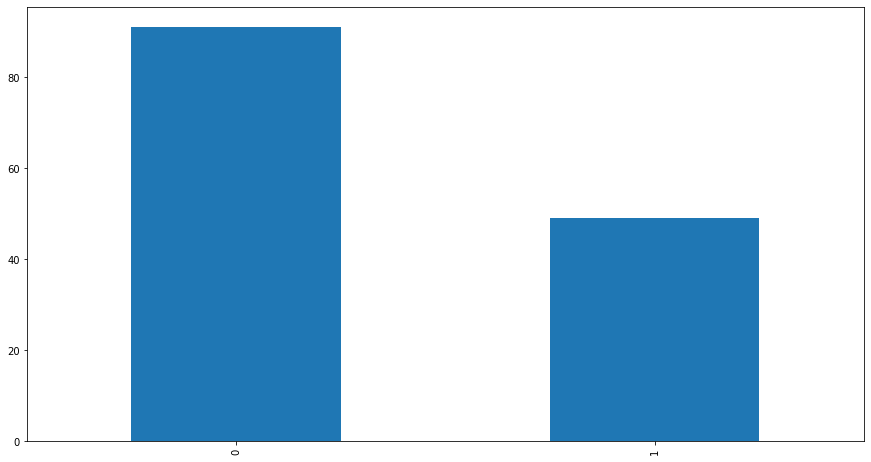

In [50]:
# split data into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
# bin  into 2 groups
print(y_train['rpe'].mean())
print(y_test['rpe'].mean())
y_train_classif =  y_train['rpe'] > 4     #y_train['rpe'].mean()
y_test_classif =  y_test['rpe'] > 4 

y_train_classif=y_train_classif.astype(int)    # convert to 0/1
y_train_classif.value_counts().plot(kind='bar')

y_train_classif

2/2 [==============================] - 0s 4ms/step


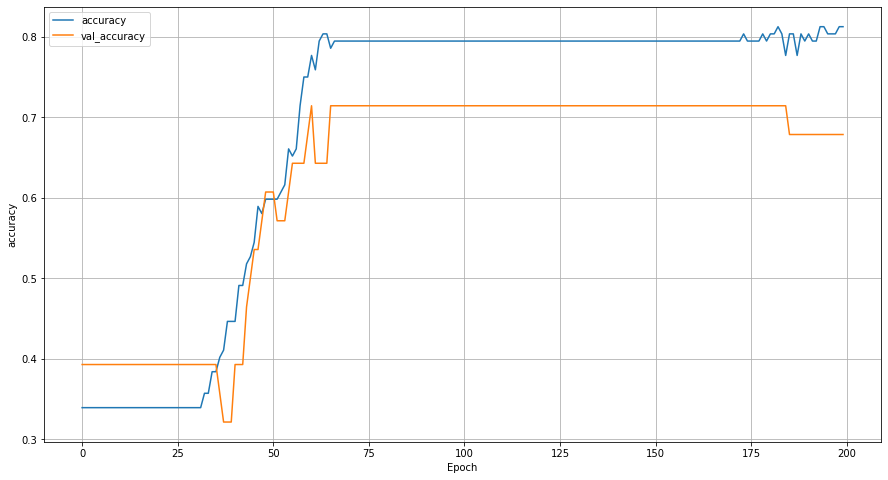

5/5 [==============================] - 0s 3ms/step
Length of sequence: 10000
Best Threshold: 0.2981 with F-Score: 0.7115
Train AUC = 0.8141960080735591


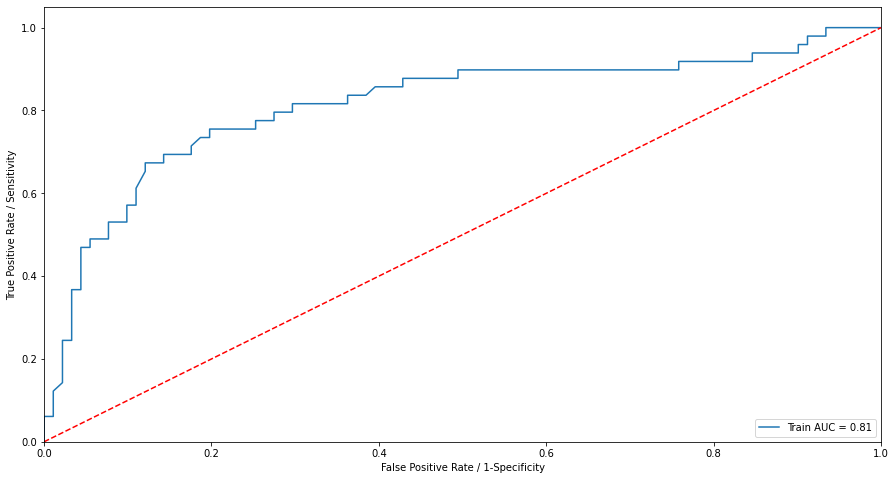

Train set classification report
              precision    recall  f1-score   support

           0     0.8333    0.8242    0.8287        91
           1     0.6800    0.6939    0.6869        49

    accuracy                         0.7786       140
   macro avg     0.7567    0.7590    0.7578       140
weighted avg     0.7797    0.7786    0.7791       140

2/2 [==============================] - 0s 5ms/step
Test AUC = 0.5717592592592592


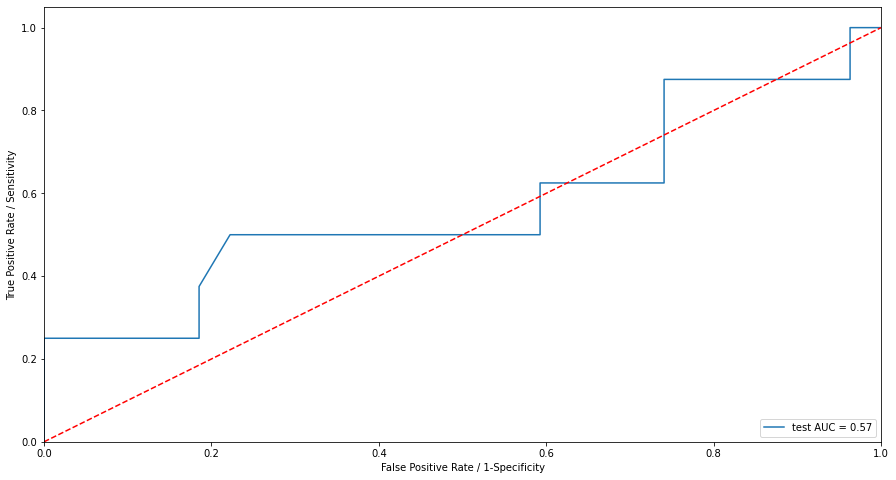

Test set classification report
              precision    recall  f1-score   support

       False     0.8261    0.7037    0.7600        27
        True     0.3333    0.5000    0.4000         8

    accuracy                         0.6571        35
   macro avg     0.5797    0.6019    0.5800        35
weighted avg     0.7135    0.6571    0.6777        35



In [53]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, regularizers
from keras.layers import preprocessing
from sklearn import metrics
from sklearn.metrics import f1_score

# The following variables are the main hyperparameters.
learning_rate = 0.001
epochs = 200
batch_size = 8
classification_threshold = 0.3 #0.5   

# class weights
# A best practice for using the class weighting is to use 
# the inverse of the class distribution present in the training dataset.
# In our case this is 90:50
class_weights = {0:1, 1:2} #{0: 4., 1: 1}

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]

# Normalizer
normalizer = layers.Normalization()
normalizer.adapt(np.array(X_train))

# Build NN
number_of_inputs= X_train.shape[1]
model = keras.Sequential([normalizer,
                          layers.Dense(10, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(10, activation='relu'),
                          layers.Dense(1, activation='sigmoid') ]) # output layer for classification


#Compile   
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),                                                   
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

 
# fit
history = model.fit(x=X_train, 
                    y=y_train_classif, 
                    batch_size=batch_size,
                    epochs=epochs,
                    class_weight=class_weights,
                    verbose=0,
                    validation_split = 0.2)  # Calculate validation results on 20% of the training data)

# Get prediction probabilities for the train set
train_predict_prob=model.predict(X_train)
train_predicted_prob=np.argmax(train_predict_prob,axis=1)

# Get prediction probabilities for the test set
test_predict_prob=model.predict(X_test)
test_predicted_prob = np.argmax(test_predict_prob,axis=1)

# The list of epochs is stored separately from the rest of history.
epochs = history.epoch

# Isolate the classification metric for each epoch.
hist = pd.DataFrame(history.history)
# print(hist)

# plot curve
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')

# plt.ylim([1,y_lim])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)
plt.show()

# -------------- Metrics on train set

# predict using model
y_pred = model.predict(X_train)

# Array for finding the optimal threshold
thresholds = np.arange(0.0, 1.0, 0.0001)
fscore = np.zeros(shape=(len(thresholds)))
print('Length of sequence: {}'.format(len(thresholds)))

# Fit the model
for index, elem in enumerate(thresholds):
    # Corrected probabilities
    y_pred_prob = (y_pred > elem).astype('int')
    # Calculate the f-score
    fscore[index] = f1_score(y_train_classif, y_pred_prob)

# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))


# ROC & AUC

from sklearn.metrics import roc_auc_score
print(f'Train AUC = {roc_auc_score(y_train_classif, y_pred)}')

logit_roc_auc_train = metrics.roc_auc_score(y_train_classif, y_pred)
fpr_train, tpr_train, thresholds = metrics.roc_curve(y_train_classif, y_pred)

plt.figure()
plt.plot(fpr_train, tpr_train, label='Train AUC = %0.2f' % logit_roc_auc_train)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate / 1-Specificity')
plt.ylabel('True Positive Rate / Sensitivity')
plt.legend(loc="lower right")
plt.show()

# accuracy, precision, recall, F1 from classification_report
from sklearn.metrics import classification_report
y_pred = np.round(y_pred) # classification_report needs a binary input
report = classification_report(y_train_classif, y_pred, digits=4)
print("Train set classification report")
print(report)

# -------------- Metrics on holdout set

# predict using model
y_pred = model.predict(X_test)

# ROC & AUC
# area_under_ROC = bc.curve_ROC_plot(true_y= y_test_classif,
#                                    predicted_proba = test_predicted_prob)
# area_under_ROC
print(f'Test AUC = {roc_auc_score(y_test_classif, y_pred)}')

logit_roc_auc_test = metrics.roc_auc_score(y_test_classif, y_pred)
fpr_test, tpr_test, thresholds = metrics.roc_curve(y_test_classif, y_pred)

plt.figure()
plt.plot(fpr_test, tpr_test, label='test AUC = %0.2f' % logit_roc_auc_test)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate / 1-Specificity')
plt.ylabel('True Positive Rate / Sensitivity')
plt.legend(loc="lower right")
plt.show()

# accuracy, precision, recall, F1 from classification_report
from sklearn.metrics import classification_report
y_pred = np.round(y_pred) # classification_report needs a binary input
report = classification_report(y_test_classif, y_pred, digits=4)
print("Test set classification report")
print(report)
